## Predict an accurate date of  delivery 
Lorenzo Antolini, Simone Lu, Luca Schisano Enrico Romano

In order to predict an accurate date of delivery, with the following code, we will try to predict a delivery time, With this predicted delivery time, we can know when the package will reach the customer. 

Firstly, we merged together customers, orders, order_items and products in order to consider some important features for the delivery prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
import warnings
warnings.filterwarnings('ignore')
from numpy import mean, median, sin, cos, sqrt, arctan2, radians, std, select, percentile,corrcoef, round
from seaborn import boxplot
from statistics import mode
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
from time import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
lr=LogisticRegression()
dt=DecisionTreeClassifier()
knn=KNeighborsClassifier()
rf=RandomForestClassifier()
ada=AdaBoostClassifier()
bag=BaggingClassifier()
xtree=ExtraTreesClassifier()
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
count=CountVectorizer()
from sklearn.decomposition import PCA


In [2]:
# assign dataset names
list_of_names = ['01.geo','02.customers','03.sellers','04.order_status','05.order_items',
                '06.order_payments','07.product_reviews','08.products']
  
# create empty list
df = []
  
# append datasets into the list
for i in range(len(list_of_names)):
    temp_df = pd.read_csv (list_of_names [i] + ".csv", encoding="ISO-8859-1",delimiter = ";")
    df.append(temp_df)
    
    

In [3]:
geoloc =df[0] 
customers =df[1] 
sellers =df[2]  
orders =df[3]  
order_items =df[4]
order_payments =df[5]
order_reviews =df[6]
products =df[7]

In [4]:
merge_df=customers.merge(orders,on='customer_id',how='inner')

In [5]:
merge_df=merge_df.merge(order_items,on='order_id',how='inner')

In [6]:
merge_df=merge_df.merge(products,on='product_id',how='inner')

We have extracted the month from the ts_order_purchase variable, because it represents our main interest.

In [7]:
merge_df['purchase_month']=pd.DatetimeIndex(merge_df['ts_order_purchase']).month

In [8]:
merge_df=merge_df[['customer_id', 'customer_unique_id', 'customer_city', 'order_id',
       'order_status', 'ts_order_purchase',
       'ts_order_delivered_customer', 'ts_order_estimated_delivery',
       'product_id', 'price', 'product_category_name', 'product_weight_gr', 'product_length_cm', 'product_height_cm',
       'product_width_cm','product_photo_quantity','purchase_month']]

In [9]:
merge_df['ts_order_estimated_delivery'] = pd.to_datetime(merge_df['ts_order_estimated_delivery'])
merge_df['ts_order_delivered_customer'] = pd.to_datetime(merge_df['ts_order_delivered_customer'])
merge_df['ts_order_purchase'] = pd.to_datetime(merge_df['ts_order_purchase'])

Looking at our data, it's easy to see all the "id" related fields are not relevant in predicting delivery time, thus all of these will be removed. as for the purchase timestamp, we've already extracted the month into the 'purchase month' column, which is the relevant parameter we need.

After, we create our target variable: <b>delivery time</b>.

In [10]:
param_df=merge_df.drop(['customer_id', 'customer_unique_id', 'order_id',
       'ts_order_purchase','customer_city',
       'ts_order_delivered_customer', 'ts_order_estimated_delivery','product_id'],axis=1)
param_df=param_df[param_df['order_status'].str.contains('delivered')]

In [11]:
param_df.columns

Index(['order_status', 'price', 'product_category_name', 'product_weight_gr',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_photo_quantity', 'purchase_month'],
      dtype='object')

In [12]:
#we make new features as well as the first target value 'delivery time'
param_df['product_volume_cm3']=param_df['product_length_cm']*param_df['product_height_cm']*param_df['product_width_cm']


In [13]:
param_df['delivery_time']=(merge_df['ts_order_delivered_customer']-merge_df['ts_order_purchase']).dt.days


In [14]:
param_df=param_df.drop(['order_status','product_length_cm','product_height_cm','product_width_cm'], axis=1)

In [15]:
param_df.columns

Index(['price', 'product_category_name', 'product_weight_gr',
       'product_photo_quantity', 'purchase_month', 'product_volume_cm3',
       'delivery_time'],
      dtype='object')

We are ready to begin our first model to predict delivery time:

In [16]:
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler,StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_absolute_error

Firstly, is important to remove NaN values

In [17]:
param_df.isnull().sum()

price                        0
product_category_name     1537
product_weight_gr           18
product_photo_quantity    1537
purchase_month               0
product_volume_cm3          18
delivery_time                8
dtype: int64

In [18]:
param_df=param_df.dropna()

Then, we selected our X and y. As we said previously, the target variable is the delivery time, so it is our Y.

In [19]:
X=param_df.drop(['delivery_time','price','product_photo_quantity',],axis=1)
y=param_df.delivery_time

Preprocessing data. We encode categorical variables. 

In [20]:
preprocessor=make_column_transformer(
    (OneHotEncoder(),['product_category_name', 'purchase_month']),
    (SimpleImputer(strategy='median'), ['product_weight_gr', 'product_volume_cm3'])
)

Then, we stardardize X and Y

In [21]:
X=preprocessor.fit_transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)
scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

After these pre-processing steps, we can run our models. 

Firstly we have done a XGboost algorithm and then a Random Forest.

In [63]:
xgbmodel = XGBRegressor(n_estimators=500, learning_rate=0.05, n_jobs=4)
xgbmodel.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)],
             verbose=False)
xgbmodel.fit(X_train, y_train)
predictions=xgbmodel.predict(X_valid)
mae=mean_absolute_error(predictions, y_valid)

In [64]:
#pipe=make_pipeline(preprocessor,xgbmodel)
kfold = KFold(n_splits=10, shuffle=True)
results=cross_val_score(xgbmodel,X,y, cv=kfold)
#print("cross-validated mae: " + str(mean_absolute_error(cv_pred, y_valid)))
print("XGBRegressor Accuracy: %.2f%% (std: %.2f%%), mae: %.2f" % (results.mean()*100, results.std()*100, mae))

XGBRegressor Accuracy: 29.23% (std: 0.39%), mae: 79.82


In [75]:
pd.DataFrame(predictions).describe()

,0
count,21736.000000
mean,12.415795
std,63.781681
min,-224.477417
25%,-36.712257
50%,10.198768
75%,69.406860
max,215.788010


In [65]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=200, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_valid)
print("Random Forest Regressor's Mean Absolute Error: " + str(mean_absolute_error(y_pred, y_valid)))

Random Forest Regressor's Mean Absolute Error: 77.68461501450754


In [76]:
pd.DataFrame(y_pred).describe()

,0
count,21736.000000
mean,11.914010
std,81.896179
min,-305.369838
25%,-36.416232
50%,10.477526
75%,63.300647
max,372.683167


## Delivery Performance

In [5]:
df = pd.merge(orders,customers,on='customer_id')
df = df.merge(order_items, on='order_id')
df = df.merge(order_payments, on='order_id')
df = df.merge(products, on='product_id')
df = df.merge(sellers, on='seller_id')
df = df.merge(order_reviews, on='order_id' )
df.head()

,order_id,customer_id,order_status,ts_order_purchase,ts_order_approved,ts_order_delivered_carrier,ts_order_delivered_customer,ts_order_estimated_delivery,customer_unique_id,customer_autonomous_community,...,product_weight_gr,product_length_cm,product_height_cm,product_width_cm,product_photo_quantity,seller_autonomous_community,seller_city,product_id_y,review_score,review_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,02/10/2018 10:56,02/10/2018 11:07,04/10/2018 19:55,10/10/2018 21:25,18/10/2018 00:00,7c396fd4830fd04220f754e42b4e5bff,Comunidad de Madrid,...,500.0,19.0,8.0,13.0,4.0,Andalucía,Málaga,87285b34884572647811a353c7ac498a,5,12/10/2018 03:43
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,02/10/2018 10:56,02/10/2018 11:07,04/10/2018 19:55,10/10/2018 21:25,18/10/2018 00:00,7c396fd4830fd04220f754e42b4e5bff,Comunidad de Madrid,...,500.0,19.0,8.0,13.0,4.0,Andalucía,Málaga,87285b34884572647811a353c7ac498a,5,12/10/2018 03:43
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,02/10/2018 10:56,02/10/2018 11:07,04/10/2018 19:55,10/10/2018 21:25,18/10/2018 00:00,7c396fd4830fd04220f754e42b4e5bff,Comunidad de Madrid,...,500.0,19.0,8.0,13.0,4.0,Andalucía,Málaga,87285b34884572647811a353c7ac498a,5,12/10/2018 03:43
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,15/08/2018 18:29,15/08/2018 20:05,17/08/2018 15:28,18/08/2018 14:44,28/08/2018 00:00,3a51803cc0d012c3b5dc8b7528cb05f7,Comunidad de Madrid,...,500.0,19.0,8.0,13.0,4.0,Andalucía,Málaga,87285b34884572647811a353c7ac498a,5,20/08/2018 15:16
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,02/08/2018 18:24,02/08/2018 18:43,04/08/2018 17:35,07/08/2018 18:30,15/08/2018 00:00,ef0996a1a279c26e7ecbd737be23d235,Comunidad de Madrid,...,500.0,19.0,8.0,13.0,4.0,Andalucía,Málaga,87285b34884572647811a353c7ac498a,1,08/08/2018 23:26


In [6]:
df = df.dropna()

In [7]:
df=df.reset_index()
df.drop(['index'],axis=1,inplace=True)

In [8]:
df = df.sort_values("customer_id")
df = df.reset_index()
df.drop(['index'],axis=1,inplace=True)

In [9]:
df['price'] = df['price'].str.replace(',', '.').astype(float)

In [12]:
df.dropna(subset=['ts_order_delivered_customer'],inplace=True)
df.reset_index(inplace=True,drop=True)

In [13]:
df_diff = df[['ts_order_delivered_customer','ts_order_estimated_delivery']]

df_diff

,ts_order_delivered_customer,ts_order_estimated_delivery
0,28/11/2018 15:41,04/12/2018 00:00
1,25/07/2018 18:57,04/08/2018 00:00
2,06/03/2018 08:57,22/03/2018 00:00
3,13/09/2018 20:06,14/09/2018 00:00
4,13/04/2019 20:21,18/04/2019 00:00
...,...,...
121704,10/04/2019 17:20,27/04/2019 00:00
121705,08/06/2019 18:03,29/06/2019 00:00
121706,18/06/2019 18:33,25/06/2019 00:00
121707,14/09/2018 19:47,26/09/2018 00:00


In [14]:
import datetime
def date_convert(date_to_convert):
     return datetime.datetime.strptime(date_to_convert, '%d/%m/%Y %H:%M').strftime('%d/%m/%Y %H:%M')

In [16]:
df_diff['delivered'] = df['ts_order_delivered_customer'].apply(date_convert)
df_diff['estimated'] = df['ts_order_estimated_delivery'].apply(date_convert)

In [17]:
df_diff

,ts_order_delivered_customer,ts_order_estimated_delivery,delivered,estimated
0,28/11/2018 15:41,04/12/2018 00:00,28/11/2018 15:41,04/12/2018 00:00
1,25/07/2018 18:57,04/08/2018 00:00,25/07/2018 18:57,04/08/2018 00:00
2,06/03/2018 08:57,22/03/2018 00:00,06/03/2018 08:57,22/03/2018 00:00
3,13/09/2018 20:06,14/09/2018 00:00,13/09/2018 20:06,14/09/2018 00:00
4,13/04/2019 20:21,18/04/2019 00:00,13/04/2019 20:21,18/04/2019 00:00
...,...,...,...,...
121704,10/04/2019 17:20,27/04/2019 00:00,10/04/2019 17:20,27/04/2019 00:00
121705,08/06/2019 18:03,29/06/2019 00:00,08/06/2019 18:03,29/06/2019 00:00
121706,18/06/2019 18:33,25/06/2019 00:00,18/06/2019 18:33,25/06/2019 00:00
121707,14/09/2018 19:47,26/09/2018 00:00,14/09/2018 19:47,26/09/2018 00:00


In [18]:
df_diff.drop(['ts_order_delivered_customer'],axis=1,inplace=True)
df_diff.drop(['ts_order_estimated_delivery'],axis=1,inplace=True)

In [19]:
df_diff

,delivered,estimated
0,28/11/2018 15:41,04/12/2018 00:00
1,25/07/2018 18:57,04/08/2018 00:00
2,06/03/2018 08:57,22/03/2018 00:00
3,13/09/2018 20:06,14/09/2018 00:00
4,13/04/2019 20:21,18/04/2019 00:00
...,...,...
121704,10/04/2019 17:20,27/04/2019 00:00
121705,08/06/2019 18:03,29/06/2019 00:00
121706,18/06/2019 18:33,25/06/2019 00:00
121707,14/09/2018 19:47,26/09/2018 00:00


In [21]:
time = []
i=0
while i < len(df):
    time_1 = datetime.datetime.strptime(df_diff['estimated'][i],'%d/%m/%Y %H:%M')
    time_2 = datetime.datetime.strptime(df_diff['delivered'][i],'%d/%m/%Y %H:%M')
    time_interval = time_2 - time_1    
    time.append(time_interval)
    
    i=i+1

In [22]:
df_diff['Difference'] = time

In [23]:
df_diff['Difference'] = df_diff['Difference'].dt.days

In [24]:
df_diff

,delivered,estimated,Difference
0,28/11/2018 15:41,04/12/2018 00:00,-6
1,25/07/2018 18:57,04/08/2018 00:00,-10
2,06/03/2018 08:57,22/03/2018 00:00,-16
3,13/09/2018 20:06,14/09/2018 00:00,-1
4,13/04/2019 20:21,18/04/2019 00:00,-5
...,...,...,...
121704,10/04/2019 17:20,27/04/2019 00:00,-17
121705,08/06/2019 18:03,29/06/2019 00:00,-21
121706,18/06/2019 18:33,25/06/2019 00:00,-7
121707,14/09/2018 19:47,26/09/2018 00:00,-12


In [25]:
pd.to_datetime(df_diff['delivered'], format='%d/%m/%Y %H:%M')

0        2018-11-28 15:41:00
1        2018-07-25 18:57:00
2        2018-03-06 08:57:00
3        2018-09-13 20:06:00
4        2019-04-13 20:21:00
                 ...        
121704   2019-04-10 17:20:00
121705   2019-06-08 18:03:00
121706   2019-06-18 18:33:00
121707   2018-09-14 19:47:00
121708   2018-09-14 19:47:00
Name: delivered, Length: 121709, dtype: datetime64[ns]

In [26]:
def date_reconvert(date_to_convert):
     return pd.to_datetime(date_to_convert, format='%d/%m/%Y %H:%M')

In [27]:
df_diff['delivered'] = df['ts_order_delivered_customer'].apply(date_reconvert)
df_diff['estimated'] = df['ts_order_estimated_delivery'].apply(date_reconvert)

In [28]:
df_diff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121709 entries, 0 to 121708
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   delivered   121709 non-null  datetime64[ns]
 1   estimated   121709 non-null  datetime64[ns]
 2   Difference  121709 non-null  int64         
dtypes: datetime64[ns](2), int64(1)
memory usage: 2.8 MB


In [29]:
df_plot = df_diff[['estimated','Difference']]

In [30]:
df_plot = df_plot.set_index('estimated')

In [31]:
df_plot = df_plot.sort_index()

<AxesSubplot:xlabel='estimated'>

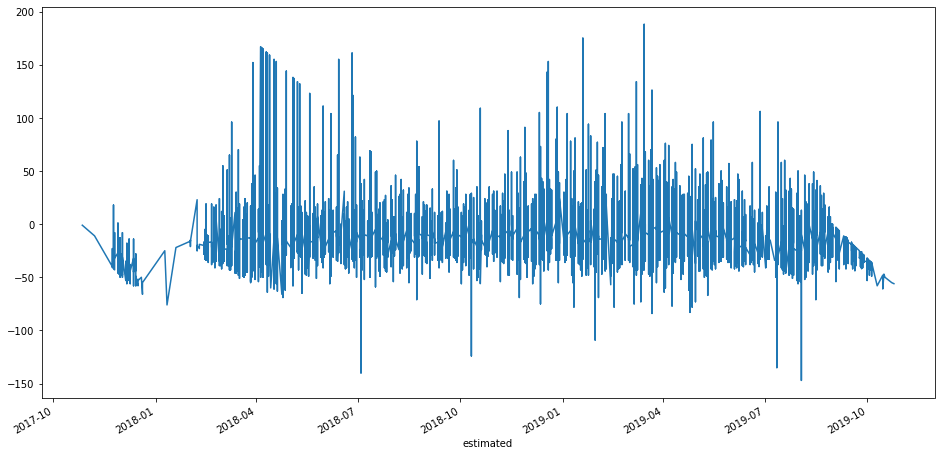

In [32]:
fig = plt.figure(figsize=(16, 8))
df_plot['Difference'].plot()

In [33]:
q_70 = int(len(df_plot.index) * .7)
df_train = df_plot[:q_70]
df_test = df_plot[q_70:]

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(df_train)
df_scaled = scaler.transform(df_train)
df_scaled.shape

(85196, 1)

In [35]:
def df_to_X_y(df,windowsize):
    X=[]
    y=[]
    for i in range(len(df_scaled)-windowsize):
        row = [[a] for a in df_scaled[i:i+windowsize]]
        X.append(row)
        label = df_scaled[i+windowsize]
        y.append(label)
        
    return np.array(X), np.array(y)

In [36]:
Close = df_train['Difference']
WINDOWSIZE = 5
X_5,y_5 = df_to_X_y(Close, WINDOWSIZE)
Close.shape, X_5.shape, y_5.shape

((85196,), (85191, 5, 1, 1), (85191, 1))

In [37]:
X_5 = np.reshape(X_5,(X_5.shape[0], X_5.shape[1], X_5.shape[2]))
y_5 = np.reshape(y_5,(y_5.shape[0],))

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_5.shape[1],1)))
model.add(LSTM(20, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [41]:
model.compile(loss='mse', 
              optimizer='adam',
              metrics=['mean_absolute_error'])

In [42]:
model.fit(X_5, y_5, epochs=20, batch_size=64)

Epoch 1/20
1332/1332 [==============================] - 23s 13ms/step - loss: 0.0015 - mean_absolute_error: 0.0220
Epoch 2/20
1332/1332 [==============================] - 16s 12ms/step - loss: 9.3564e-04 - mean_absolute_error: 0.0197
Epoch 3/20
1332/1332 [==============================] - 15s 11ms/step - loss: 9.3954e-04 - mean_absolute_error: 0.0198
Epoch 4/20
1332/1332 [==============================] - 15s 11ms/step - loss: 9.3422e-04 - mean_absolute_error: 0.0198
Epoch 5/20
1332/1332 [==============================] - 15s 11ms/step - loss: 9.3205e-04 - mean_absolute_error: 0.0198
Epoch 6/20
1332/1332 [==============================] - 15s 11ms/step - loss: 9.2635e-04 - mean_absolute_error: 0.0197
Epoch 7/20
1332/1332 [==============================] - 15s 11ms/step - loss: 9.2502e-04 - mean_absolute_error: 0.0197
Epoch 8/20
1332/1332 [==============================] - 15s 11ms/step - loss: 9.1983e-04 - mean_absolute_error: 0.0196
Epoch 9/20
1332/1332 [==============================

In [43]:
dataset_total = pd.concat((df_train,df_test), axis=0)

In [44]:
inputs = dataset_total[len(dataset_total)-len(df_test)-WINDOWSIZE:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [45]:
X_test = []
for i in range(WINDOWSIZE,len(inputs)):
    X_test.append(inputs[i-WINDOWSIZE:i, 0])

In [46]:
X_test = np.array(X_test)

In [47]:
X_test.shape

(36513, 5)

In [48]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(36513, 5, 1)

In [49]:
test_predictions5 = model.predict(X_test)
test_predictions5 = scaler.inverse_transform(test_predictions5)

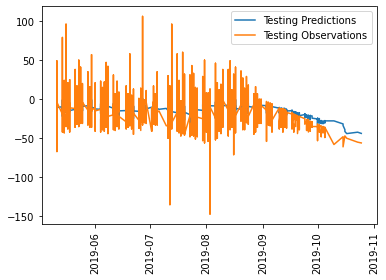

In [50]:
plt.plot(df_test.index, test_predictions5)
plt.plot(df_test.index, df_test.values)
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [51]:
te = df_test.values

In [52]:
df_test.index.shape

(36513,)

In [53]:
test_predictions5 = np.reshape(test_predictions5,(df_test.index.shape[0],))

In [54]:
te = np.reshape(te,(df_test.index.shape[0],))

In [55]:
test_results5 = pd.DataFrame(data={'Test Predictions':test_predictions5, 'Actuals':te},index=df_test.index)
test_results5

,Test Predictions,Actuals
estimated,,
2019-05-11,-11.806124,3
2019-05-11,-9.419695,-43
2019-05-11,-13.421645,-2
2019-05-11,-10.748589,-15
2019-05-11,-11.973964,-18
...,...,...
2019-10-16,-38.907078,-47
2019-10-16,-41.299221,-47
2019-10-17,-44.045555,-50


In [56]:
rmse5=np.sqrt(np.mean(((test_results5['Test Predictions']- test_results5['Actuals'])**2)))
rmse5

9.043119346073246

In [57]:
mae5 = np.mean(np.abs(test_results5['Test Predictions']-test_results5['Actuals']))
mae5

6.732986927032471

## How to improve delivery performance?

In order to find ways to optimise delivery times, we are focusing on logistic regression.

Our goal here is to find deliveries that have suffered and to suggest solutions to improve the customer experience. It is natural that this requirement requires us to analyse the dataset of deliveries and their columns.

In order to do a better analysis, is important to have the zip codes of the spanish cities. So, we created this variable and add it to our deliveries dataset. 

In [58]:
zip(geoloc.geo_autonomous_community, geoloc.geo_admin1_code)
list(zip(geoloc.geo_autonomous_community, geoloc.geo_admin1_code))
equiv = dict(zip(geoloc.geo_autonomous_community, geoloc.geo_admin1_code))
customers['cust_zip_code'] = customers['customer_autonomous_community'].map(equiv)
sellers['sell_zip_code'] = sellers['seller_autonomous_community'].map(equiv)

In [59]:
customers.columns

Index(['customer_id', 'customer_unique_id', 'customer_autonomous_community',
       'customer_city', 'cust_zip_code'],
      dtype='object')

In [60]:
deliveries=customers.rename(columns={'cust_zip_code':'geolocation_zip_code_prefix'})

In [61]:
deliveries = deliveries[['customer_id', 'geolocation_zip_code_prefix', 'customer_city', 'customer_autonomous_community']]

In [62]:
deliveries = deliveries.merge(orders, on='customer_id', how='inner')

In [63]:
deliveries = deliveries.merge(order_items, on='order_id', how='inner')

In [64]:
deliveries.columns

Index(['customer_id', 'geolocation_zip_code_prefix', 'customer_city',
       'customer_autonomous_community', 'order_id', 'order_status',
       'ts_order_purchase', 'ts_order_approved', 'ts_order_delivered_carrier',
       'ts_order_delivered_customer', 'ts_order_estimated_delivery',
       'order_item_sequence_id', 'product_id', 'price', 'shipping_cost',
       'seller_id', 'max_shipping_seller_date'],
      dtype='object')

In [65]:
deliveries = deliveries[['customer_id', 'geolocation_zip_code_prefix', 'customer_city',
                     'customer_autonomous_community', 'ts_order_approved', 'ts_order_delivered_carrier', 
                     'ts_order_delivered_customer', 
                     'ts_order_estimated_delivery', 'max_shipping_seller_date', 'shipping_cost']]

In [66]:
deliveries.info() #transfom shipping cost to float?

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112695 entries, 0 to 112694
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   customer_id                    112695 non-null  object
 1   geolocation_zip_code_prefix    112695 non-null  int64 
 2   customer_city                  112695 non-null  object
 3   customer_autonomous_community  112695 non-null  object
 4   ts_order_approved              112670 non-null  object
 5   ts_order_delivered_carrier     111481 non-null  object
 6   ts_order_delivered_customer    110221 non-null  object
 7   ts_order_estimated_delivery    112675 non-null  object
 8   max_shipping_seller_date       112695 non-null  object
 9   shipping_cost                  112695 non-null  object
dtypes: int64(1), object(9)
memory usage: 9.5+ MB


Transform object to datetime

In [67]:
deliveries['ts_order_estimated_delivery'] = pd.to_datetime(deliveries['ts_order_estimated_delivery'])
deliveries['ts_order_delivered_customer'] = pd.to_datetime(deliveries['ts_order_delivered_customer'])
deliveries['ts_order_delivered_carrier'] = pd.to_datetime(deliveries['ts_order_delivered_carrier'])
deliveries['ts_order_approved'] = pd.to_datetime(deliveries['ts_order_approved'])

We have noticed that there is a good chance of gaining insights by comparing the columns "ts_order_estimated_delivery" and "ts_order_delivered_customer", which represent the estimated time the product arrived at the customer's address, and the time the product actually took to arrive. Based on this, we created a new column called "diff". which represents the difference between the estimated date and the actual date.


In [68]:
deliveries['diff'] = deliveries['ts_order_estimated_delivery'] - deliveries['ts_order_delivered_customer']

In [69]:
deliveries = deliveries.dropna()

In [70]:
deliveries[deliveries['diff'] < '0 days']

,customer_id,geolocation_zip_code_prefix,customer_city,customer_autonomous_community,ts_order_approved,ts_order_delivered_carrier,ts_order_delivered_customer,ts_order_estimated_delivery,max_shipping_seller_date,shipping_cost,diff
0,06b8999e2fba1a1fbc88172c00ba8bc7,51,Málaga,Andalucía,2018-05-16 15:22:00,2018-05-23 10:47:00,2018-05-25 10:35:00,2018-05-06,22/05/2018 15:22,"21,88",-20 days +13:25:00
2,4e7b3e00288586ebd08712fdd0374a03,29,Madrid,Comunidad de Madrid,2019-05-20 16:19:00,2019-11-06 14:31:00,2019-06-14 17:58:00,2019-06-13,05/06/2019 16:19,"17,79",-2 days +06:02:00
4,4f2d8ab171c80ec8364f7c12e35b23ad,51,Málaga,Andalucía,2019-07-29 10:10:00,2019-07-30 15:16:00,2019-09-08 20:55:00,2019-08-15,31/07/2019 10:10,"22,25",-25 days +03:05:00
5,879864dab9bc3047522c92c82e1212b8,55,Valladolid,Castilla y León,2018-09-14 18:25:00,2018-09-18 21:27:00,2018-09-28 17:32:00,2018-04-10,20/09/2018 18:25,"22,31",-172 days +06:28:00
7,5e274e7a0c3809e14aba7ad5aae0d407,29,Alcorcón,Comunidad de Madrid,2018-11-16 19:55:00,2018-11-22 16:46:00,2018-11-27 12:44:00,2018-08-12,22/11/2018 19:55,"16,11",-108 days +11:16:00
...,...,...,...,...,...,...,...,...,...,...,...
112687,14308d2303a3e2bdf4939b86c46d2679,57,Badajoz,Extremadura,2018-03-15 21:04:00,2018-03-20 08:34:00,2018-05-04 11:07:00,2018-04-26,28/03/2018 21:04,"24,42",-9 days +12:53:00
112689,7fe2e80252a9ea476f950ae8f85b0f8f,29,Madrid,Comunidad de Madrid,2018-12-18 00:17:00,2018-12-20 18:52:00,2019-04-01 13:08:00,2019-01-23,03/01/2019 00:17,"20,88",-69 days +10:52:00
112691,e7b71a9017aa05c9a7fd292d714858e8,51,Granada,Andalucía,2019-04-04 08:35:00,2019-05-04 18:42:00,2019-11-04 18:54:00,2019-04-20,10/04/2019 08:35,"14,16",-199 days +05:06:00
112692,5e28dfe12db7fb50a4b2f691faecea5e,7,Palma de Mallorca - Mallorca,Baleares,2019-08-04 20:30:00,2019-09-04 17:52:00,2019-09-05 19:03:00,2019-02-05,12/04/2019 20:30,"19,04",-213 days +04:57:00


We have a hypothesis. Maybe these delays are due to some process in the delivery of the product to the carrier? The "ts_order_delivered_carrier" column can help us verify this.

In order to do this verification, we have transformed our variable in a format that can be worked with mathematical operations.

In [71]:
deliveries['shipping_time'] = deliveries['ts_order_delivered_carrier'].dt.hour
deliveries['diff'] = deliveries['diff'].astype(str)
deliveries['diff'] = deliveries['diff'].str.replace(' days.*', '')

In [72]:
deliveries

,customer_id,geolocation_zip_code_prefix,customer_city,customer_autonomous_community,ts_order_approved,ts_order_delivered_carrier,ts_order_delivered_customer,ts_order_estimated_delivery,max_shipping_seller_date,shipping_cost,diff,shipping_time
0,06b8999e2fba1a1fbc88172c00ba8bc7,51,Málaga,Andalucía,2018-05-16 15:22:00,2018-05-23 10:47:00,2018-05-25 10:35:00,2018-05-06,22/05/2018 15:22,"21,88",-20,10
1,18955e83d337fd6b2def6b18a428ac77,51,Granada,Andalucía,2019-12-01 20:58:00,2019-01-15 17:14:00,2019-01-29 12:41:00,2019-06-02,18/01/2019 20:58,"46,48",123,17
2,4e7b3e00288586ebd08712fdd0374a03,29,Madrid,Comunidad de Madrid,2019-05-20 16:19:00,2019-11-06 14:31:00,2019-06-14 17:58:00,2019-06-13,05/06/2019 16:19,"17,79",-2,14
3,b2b6027bc5c5109e529d4dc6358b12c3,51,Jaén,Andalucía,2019-03-13 17:29:00,2019-03-27 23:22:00,2019-03-28 16:04:00,2019-10-04,27/03/2019 16:31,"23,36",189,23
4,4f2d8ab171c80ec8364f7c12e35b23ad,51,Málaga,Andalucía,2019-07-29 10:10:00,2019-07-30 15:16:00,2019-09-08 20:55:00,2019-08-15,31/07/2019 10:10,"22,25",-25,15
...,...,...,...,...,...,...,...,...,...,...,...,...
112690,17ddf5dd5d51696bb3d7c6291687be6f,29,Madrid,Comunidad de Madrid,2019-07-04 16:08:00,2019-11-04 02:08:00,2019-04-13 20:06:00,2019-04-25,12/04/2019 16:08,"13,88",11,2
112691,e7b71a9017aa05c9a7fd292d714858e8,51,Granada,Andalucía,2019-04-04 08:35:00,2019-05-04 18:42:00,2019-11-04 18:54:00,2019-04-20,10/04/2019 08:35,"14,16",-199,18
112692,5e28dfe12db7fb50a4b2f691faecea5e,7,Palma de Mallorca - Mallorca,Baleares,2019-08-04 20:30:00,2019-09-04 17:52:00,2019-09-05 19:03:00,2019-02-05,12/04/2019 20:30,"19,04",-213,17
112693,56b18e2166679b8a959d72dd06da27f9,60,Castellón,Comunidad Valenciana,2018-03-11 21:31:00,2018-06-11 18:24:00,2018-11-16 19:58:00,2018-05-12,09/11/2018 21:15,"22,07",-189,18


In [73]:
deliveries['diff'] = deliveries['diff'].astype(int)

We will now check deliveries to the carrier/post office that occurred after 6pm.

In [74]:
deliveries[deliveries['shipping_time']>18]

,customer_id,geolocation_zip_code_prefix,customer_city,customer_autonomous_community,ts_order_approved,ts_order_delivered_carrier,ts_order_delivered_customer,ts_order_estimated_delivery,max_shipping_seller_date,shipping_cost,diff,shipping_time
3,b2b6027bc5c5109e529d4dc6358b12c3,51,Jaén,Andalucía,2019-03-13 17:29:00,2019-03-27 23:22:00,2019-03-28 16:04:00,2019-10-04,27/03/2019 16:31,"23,36",189,23
5,879864dab9bc3047522c92c82e1212b8,55,Valladolid,Castilla y León,2018-09-14 18:25:00,2018-09-18 21:27:00,2018-09-28 17:32:00,2018-04-10,20/09/2018 18:25,"22,31",-172,21
8,5adf08e34b2e993982a47070956c5c65,58,Coruña,Galicia,2019-01-18 12:56:00,2019-01-18 23:25:00,2019-01-26 15:17:00,2019-02-20,30/01/2019 12:56,"14,1",24,23
10,9fb35e4ed6f0a14a4977cd9aea4042bb,29,Getafe,Comunidad de Madrid,2018-11-27 18:01:00,2018-11-28 23:04:00,2018-08-12 22:16:00,2018-12-20,01/12/2018 18:01,"15,1",129,23
13,eabebad39a88bb6f5b52376faec28612,29,Madrid,Comunidad de Madrid,2019-07-03 16:15:00,2019-12-03 23:02:00,2019-03-15 00:46:00,2019-03-19,13/03/2019 16:15,"8,4",3,23
...,...,...,...,...,...,...,...,...,...,...,...,...
112675,5eef6cce1f34954c9e7004332388ccc7,51,Almería,Andalucía,2019-03-15 03:29:00,2019-03-16 23:15:00,2019-03-23 02:47:00,2019-03-29,21/03/2019 03:29,"14,22",5,23
112677,c6ece8a5137f3c9c3a3a12302a19a2ac,29,Madrid,Comunidad de Madrid,2018-10-20 07:28:00,2018-10-23 19:13:00,2018-10-24 17:03:00,2018-01-11,26/10/2018 07:28,"7,78",-287,19
112679,0a7db3996b88954c7aa763b5dd621d5b,53,Las Palmas de Gran Canaria,Islas Canarias,2019-02-13 18:30:00,2019-02-14 20:22:00,2019-03-29 20:26:00,2019-03-15,19/02/2019 17:30,"25,66",-15,20
112683,1ed0c832c2dd99570a59260e71768bdf,29,Móstoles,Comunidad de Madrid,2018-11-14 12:15:00,2018-11-27 20:44:00,2018-12-19 19:37:00,2018-12-12,24/11/2018 12:15,"31,93",-8,20


In [75]:
## negative difference = orders that have been delivered BEFORE the estimated date, 
## positive difference == orders that have been delivered AFTER the estimated date

Let's now find out which delivery times to the carrier/courier caused the most delivery delays to the end customer.

In [76]:
deliveries[deliveries['diff'] < 0]['shipping_time'].value_counts().sort_index()

0     1019
1      622
2      227
3      102
4       71
5      119
6      283
7      387
8      780
9      965
10    1150
11    1609
12    2203
13    3052
14    4140
15    3414
16    2276
17    2261
18    2832
19    3094
20    2684
21    2238
22    1907
23    1438
Name: shipping_time, dtype: int64


In the left column we see the time, and in the right column we see the amount of delayed deliveries.

We can see a pattern, most of the delays happened after midday and before midnight.

Then, we repeat the same analysis in order to find a pattern also in the early delivered goods.

In [77]:
deliveries[deliveries['diff'] >= 0]['shipping_time'].value_counts().sort_index()

0     1789
1      891
2      449
3      208
4      115
5      183
6      500
7      795
8     1397
9     1881
10    2436
11    3077
12    3902
13    5507
14    7708
15    6487
16    4218
17    4038
18    5073
19    5601
20    4866
21    4058
22    3412
23    2741
Name: shipping_time, dtype: int64

Knowing that in this dataset there are many more early (or on time) deliveries than late ones, direct comparison did not help us. Let's calculate the delay proportion between the schedules and plot it. To do this we'll need to create a small repeating loop, done below.

In [78]:
percentage_delay_shipping_time = {}

for i in range(24):
    hour = i+1
    if hour < 24:
        percentage_delay = len(deliveries[(deliveries['shipping_time'] == hour) & (deliveries['diff'] < 0)])/len(deliveries[(deliveries['shipping_time'] == hour)])
        percentage_delay_shipping_time[hour] = percentage_delay
    else:
        percentage_delay = len(deliveries[(deliveries['shipping_time'] == 0) & (deliveries['diff'] < 0)])/len(deliveries[(deliveries['shipping_time'] == 0)])
        percentage_delay_shipping_time[hour] = percentage_delay
        

Now let's create a table in DataFrame format to see the timetables and their percentage of delay, and plot it.

In [79]:


percentage_delay_shipping_time = pd.DataFrame.from_dict(percentage_delay_shipping_time, orient='index')
percentage_delay_shipping_time['hour'] = percentage_delay_shipping_time.index
percentage_delay_shipping_time.columns = 'delay percentage', 'shipping hour'
percentage_delay_shipping_time = percentage_delay_shipping_time[['shipping hour', 'delay percentage']]



In [80]:

percentage_delay_shipping_time['delay percentage'] = percentage_delay_shipping_time['delay percentage']*100


Text(0, 0.5, 'delay percentage')

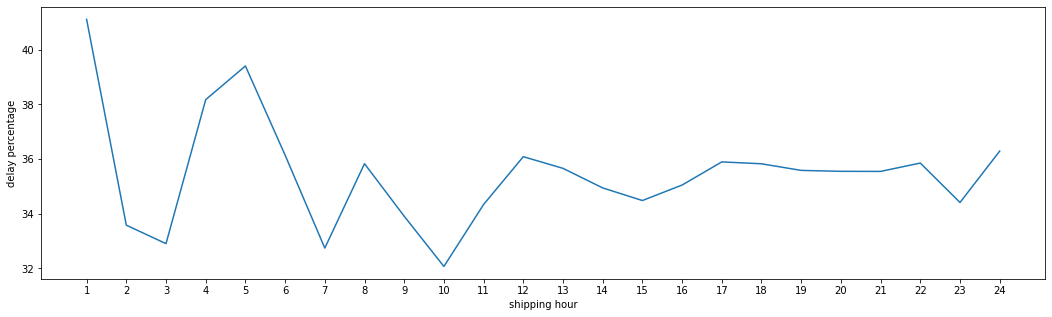

In [81]:

plt.rcParams['figure.figsize'] = 18, 5
percentage_delay_shipping_time.plot(x='shipping hour', y='delay percentage', legend=False)
plt.xticks(percentage_delay_shipping_time['shipping hour'])
plt.ylabel('delay percentage')



Apparently, shipping times with the lowest delay percentage are from 9am to  10 am and 3 a.m.. Of course, is impossible for a seller to ship a product at 3 a.m., so we do not consider this time hour. 

Now, we checked out in which of these times, sellers of the spanish e-commerce ship the most products.

Text(0.5, 1.0, 'Products dispatched to the carrier x dispatch time')

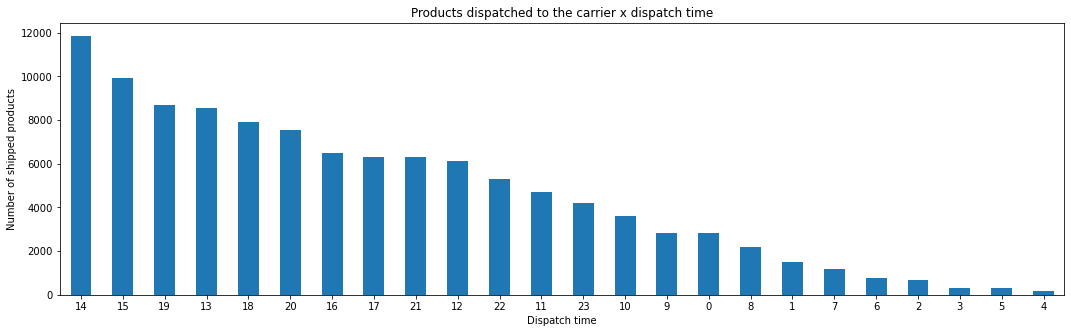

In [82]:
deliveries['shipping_time'].value_counts().plot(kind='bar', rot=0)
plt.ylabel('Number of shipped products')
plt.xlabel('Dispatch time')
plt.title('Products dispatched to the carrier x dispatch time')


Our sellers have been dispatching most products at 2pm, 3pm , which are not the best performing times for delivery without delay. There is likely to be a reduction in the delays that exist today if sellers are directed to make deliveries to the carrier/post office at the times of  9am, 10am . But this hypothesis needs to be tested.

Let's use a test statistic for that hypothesis.


In [83]:


group_a = deliveries[(deliveries['diff'] < 0) & ((deliveries['shipping_time'] == 14) | (deliveries['shipping_time'] == 15) )]



In [84]:

group_b = deliveries[(deliveries['diff'] < 0) &  ((deliveries['shipping_time'] == 9) | (deliveries['shipping_time'] == 10))]



In [85]:
xa = group_a['diff'].mean()

In [86]:
xb = group_b['diff'].mean()

In [87]:
stat_test=xb-xa

In [88]:
stat_test

0.7670583618279352

In [89]:
groups = pd.concat([group_a, group_b], ignore_index=True)

In [90]:
groups['shipping_time'].unique()

array([14, 15, 10,  9], dtype=int64)

In [91]:
allgroups = groups['diff'].to_list()

In [92]:
meandif = []

for i in range(1000):
    group_a = []
    group_b = []
    for value in allgroups:
        group = np.random.rand()
        if group >= 0.5:
            group_a.append(value)
        else:
            group_b.append(value)
    
    mean_a = np.mean(group_a)
    mean_b = np.mean(group_b)
    mean_difference = mean_b = mean_a
    meandif.append(mean_difference)

In [93]:


sampling_dist = {}

for value1 in meandif:
    if sampling_dist.get(value1, False):
        newval = sampling_dist.get(value1)
        newval += 1
    else:
        sampling_dist[value1] = 1



In [94]:


freqs = []

for key in sampling_dist:
    if key >= stat_test:
        freqs.append(key)

p_value = sum(freqs)
p_value /= 1000



In [95]:
p_value

0.0

With p_value equal to 0.0, we can say that it is statistically relevant the difference in the outcome in delivery delays between groups A and B, and these differences are not given by chance. That is, the hypothesis has statistical power.


There is a good opportunity to reduce the amount of late deliveries by simply switching the most frequent times of dispatching goods to the carrier. In the interval that this data was generated spanish e-commerce sellers were using the 2pm, 3pm  times to ship most goods, but could have had fewer delays if they used the 9am, 10am.